In [1]:
import datetime as dt
from loguru import logger

import warnings
import datetime as dt
import polars as pl
from pathlib import Path
from loguru import logger

from model import XGBoostModel, GeneticAlgorithm, fitness_function_wrapper
from pipeline import Preprocess
from model import ModelHandler
from config import get_config

In [2]:
train_start = 2007
date_col = 'tdq'
target_col = 'fperf'
val_train_window = 12
val_eval_window = 2
last_trade_date = None

In [3]:
def find_last_trading_date():
    """
    Find last trading date, which will be used for stock selection.

    Returns
    -------
    dt.datime
        Trading date.
    """

    today = dt.datetime.today()
    trade_dates = [
        dt.datetime(today.year, 3, 1),
        dt.datetime(today.year, 6, 1),
        dt.datetime(today.year, 9, 1),
        dt.datetime(today.year, 12, 1),
    ]
    past_dates = [date for date in trade_dates if date <= today]

    if past_dates:
        return max(past_dates)
    else:
        return None

last_trade_date = find_last_trading_date()
last_trade_date

datetime.datetime(2024, 9, 1, 0, 0)

In [4]:
data = pl.read_csv("../data/1_work_data/processed/proc_2024-10-18.csv", try_parse_dates=True)
data.head()

datadate,rdq,tdq,tic,sector,val_purch,val_sales,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_m,vol_q,vol_y,momentum_mom,momentum_qoq,momentum_yoy,price_mom,price_qoq,price_yoy,ni_qoq,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,rev_qoq,rev_yoy,gpm,gpm_qoq,gpm_yoy,roa,roa_qoq,roa_yoy,roe,roe_qoq,roe_yoy,fcf_yoy,cfm,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,pe,pe_qoq,pe_yoy,ev_ebitda,ev_eb_qoq,ev_eb_yoy,ltcr_yoy,itr_yoy,rtr_yoy,atr_yoy,freturn,adj_freturn,fperf,adj_fperf
date,date,date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
2007-01-31,2007-02-15,2007-03-01,"""A""","""Health Care""",0.0,8.598,37.080402,42.592688,46.374228,47.731266,51.599159,0.014809,0.012043,0.01791,-6.63701,-7.1022,-1.324112,-0.0175,-0.018727,-0.126667,0.006711,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.036145,0.096829,0.578125,-0.011905,0.034773,0.088037,-0.799034,-0.786032,0.17528,-0.806646,-0.758874,1.314607,0.072656,-0.033049,-0.06119,0.051933,0.026403,0.115807,14.209289,4.036292,2.825606,14.053467,-0.106851,-0.424184,1.314607,0.257698,0.227194,0.113024,21.755764,12.265117,1,0
2007-04-30,2007-05-14,2007-06-01,"""A""","""Health Care""",0.0,2.695,62.343397,62.077772,58.732066,56.476933,53.785471,0.016561,0.013553,0.017389,0.517117,2.392662,0.463493,0.052226,0.241648,0.097162,-0.18,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.03125,0.065375,0.590909,0.022113,0.058001,0.089666,0.018496,-0.764364,0.18256,0.041531,-0.756945,0.078838,0.228788,-0.048932,-0.09261,0.072623,0.035449,0.106275,16.705873,0.175701,3.789035,15.689363,0.116405,-0.275697,0.078838,0.192597,0.240253,0.183644,-4.911207,-0.852863,0,0
2007-07-31,2007-08-14,2007-09-01,"""A""","""Health Care""",0.0,5.747,52.575103,48.65697,49.886609,50.705963,52.386154,0.032772,0.021062,0.01607,2.010229,1.795475,1.064454,-0.057483,-0.051342,0.1375,0.504065,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,0.040909,0.108959,0.590247,-0.00112,-0.005011,0.084854,-0.053667,-0.789586,0.184611,0.011234,-0.780068,27.0,0.128093,-0.13529,-0.202801,0.094405,0.044192,0.10037,16.580932,-0.007479,4.723257,14.783464,-0.05774,-0.142223,27.0,0.187692,0.293278,0.223599,3.928572,3.443492,0,0
2007-10-31,2007-11-15,2007-12-01,"""A""","""Health Care""",0.0,2.75,59.704889,54.609299,52.512775,52.119067,52.470659,0.026217,0.017897,0.016334,4.424257,7.683146,3.097014,0.026594,0.046184,0.180712,-0.027027,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,0.052402,0.088855,0.577455,-0.021673,-0.01305,0.087529,0.031532,-0.800194,0.197279,0.068621,-0.782379,-0.057743,0.275242,-0.142226,-0.198205,0.313484,0.135903,0.357259,15.693153,-0.053542,4.562228,14.923904,0.0095,-0.051532,-0.322767,0.101257,0.142078,0.127695,-19.085361,-8.923594,0,0
2008-01-31,2008-02-13,2008-03-01,"""A""","""Health Care""",0.0,3.418,34.6395,38.84194,42.496746,44.43477,49.648431,0.018267,0.018484,0.017808,1.027843,1.878156,0.510655,-0.104447,-0.190854,-0.026399,-0.333333,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,-0.036653,0.088281,0.583632,0.010698,0.009526,0.080996,-0.074634,-0.079976,0.191617,-0.028701,0.093202,-1.535714,0.002872,-0.306119,-0.280077,0.396995,0.168878,-0.597549,13.252579,-0.155518,-0.06733,10.717445,-0.28186,-0.237381,-2.28366,0.053575,0.015282,0.055589,22.149637,16.907759,1,0


In [5]:
data = data.filter((pl.col('tdq') < last_trade_date))
data = data.filter(~pl.all_horizontal(pl.col(target_col).is_null()))

data = data.to_dummies(columns=['sector'])

# filter cols
aux_cols = ['datadate', 'rdq', 'sector'] + [t for t in get_config('model')['targets'] if t != target_col]
data = data.select([c for c in data.columns if c not in aux_cols])
data.head()

tdq,tic,val_purch,val_sales,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_m,vol_q,vol_y,momentum_mom,momentum_qoq,momentum_yoy,price_mom,price_qoq,price_yoy,ni_qoq,ni_yoy,ni_2y,ltq_qoq,ltq_yoy,ltq_2y,dlttq_yoy,rev_qoq,rev_yoy,gpm,gpm_qoq,gpm_yoy,roa,roa_qoq,roa_yoy,roe,roe_qoq,roe_yoy,fcf_yoy,cfm,cr_yoy,qr_yoy,der_yoy,dr_yoy,ltda_yoy,pe,pe_qoq,pe_yoy,ev_ebitda,ev_eb_qoq,ev_eb_yoy,ltcr_yoy,itr_yoy,rtr_yoy,atr_yoy,fperf
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
2007-03-01,"""A""",0.0,8.598,37.080402,42.592688,46.374228,47.731266,51.599159,0.014809,0.012043,0.01791,-6.63701,-7.1022,-1.324112,-0.0175,-0.018727,-0.126667,0.006711,-0.946733,0.456311,-0.0469,-0.080125,0.045535,0.0,-0.036145,0.096829,0.578125,-0.011905,0.034773,0.088037,-0.799034,-0.786032,0.17528,-0.806646,-0.758874,1.314607,0.072656,-0.033049,-0.06119,0.051933,0.026403,0.115807,14.209289,4.036292,2.825606,14.053467,-0.106851,-0.424184,1.314607,0.257698,0.227194,0.113024,1
2007-06-01,"""A""",0.0,2.695,62.343397,62.077772,58.732066,56.476933,53.785471,0.016561,0.013553,0.017389,0.517117,2.392662,0.463493,0.052226,0.241648,0.097162,-0.18,0.069565,0.294737,0.054299,-0.064022,0.096793,0.0,0.03125,0.065375,0.590909,0.022113,0.058001,0.089666,0.018496,-0.764364,0.18256,0.041531,-0.756945,0.078838,0.228788,-0.048932,-0.09261,0.072623,0.035449,0.106275,16.705873,0.175701,3.789035,15.689363,0.116405,-0.275697,0.078838,0.192597,0.240253,0.183644,0
2007-09-01,"""A""",0.0,5.747,52.575103,48.65697,49.886609,50.705963,52.386154,0.032772,0.021062,0.01607,2.010229,1.795475,1.064454,-0.057483,-0.051342,0.1375,0.504065,-0.185022,0.778846,0.002146,-0.051054,0.097532,0.0,0.040909,0.108959,0.590247,-0.00112,-0.005011,0.084854,-0.053667,-0.789586,0.184611,0.011234,-0.780068,27.0,0.128093,-0.13529,-0.202801,0.094405,0.044192,0.10037,16.580932,-0.007479,4.723257,14.783464,-0.05774,-0.142223,27.0,0.187692,0.293278,0.223599,0
2007-12-01,"""A""",0.0,2.75,59.704889,54.609299,52.512775,52.119067,52.470659,0.026217,0.017897,0.016334,4.424257,7.683146,3.097014,0.026594,0.046184,0.180712,-0.027027,0.208054,6.2,0.156317,0.16442,0.638847,0.391333,0.052402,0.088855,0.577455,-0.021673,-0.01305,0.087529,0.031532,-0.800194,0.197279,0.068621,-0.782379,-0.057743,0.275242,-0.142226,-0.198205,0.313484,0.135903,0.357259,15.693153,-0.053542,4.562228,14.923904,0.0095,-0.051532,-0.322767,0.101257,0.142078,0.127695,0
2008-03-01,"""A""",0.0,3.418,34.6395,38.84194,42.496746,44.43477,49.648431,0.018267,0.018484,0.017808,1.027843,1.878156,0.510655,-0.104447,-0.190854,-0.026399,-0.333333,-0.2,-0.957386,-0.00787,0.212104,0.114984,-0.582667,-0.036653,0.088281,0.583632,0.010698,0.009526,0.080996,-0.074634,-0.079976,0.191617,-0.028701,0.093202,-1.535714,0.002872,-0.306119,-0.280077,0.396995,0.168878,-0.597549,13.252579,-0.155518,-0.06733,10.717445,-0.28186,-0.237381,-2.28366,0.053575,0.015282,0.055589,1


In [6]:
# feature selection
cols = [
    date_col,
    'val_purch',
    'val_sales',
    'momentum_mom',
    'momentum_qoq',
    'momentum_yoy',
    'rsi_14d',
    'rsi_30d',
    'rsi_60d',
    'price_mom',
    'price_qoq',
    'price_yoy',
    target_col
]

# data = data.select(cols)

In [7]:
train = data.filter(
    (pl.col('tdq').dt.year() > 2007) &
    (pl.col('tdq').dt.year() < 2021)
)
val = data.filter(
    (pl.col('tdq').dt.year() >= 2021) &
    (pl.col('tdq').dt.year() <= 2023)
)


def get_scale():
    scale = int(
        len(train.filter(pl.col(target_col) == 0)) /
        len(train.filter(pl.col(target_col) == 1))
    )

    print(f"Scale of training data (pos/neg): {scale}")
    return scale

scale = get_scale()

X_train = train.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_train = train.select(target_col).to_pandas().values.ravel()
X_val = val.select(pl.exclude(['tic', target_col, date_col])).to_pandas()
y_val = val.select(target_col).to_pandas().values.ravel()

X_train

Scale of training data (pos/neg): 7


,val_purch,val_sales,rsi_14d,rsi_30d,rsi_60d,rsi_90d,rsi_1y,vol_m,vol_q,vol_y,...,pe,pe_qoq,pe_yoy,ev_ebitda,ev_eb_qoq,ev_eb_yoy,ltcr_yoy,itr_yoy,rtr_yoy,atr_yoy
0,0.0,3.418,34.639500,38.841940,42.496746,44.434770,49.648431,0.018267,0.018484,0.017808,...,13.252579,-0.155518,-0.067330,10.717445,-0.281860,-0.237381,-2.283660,0.053575,0.015282,0.055589
1,0.0,0.745,76.582442,65.804529,57.475763,54.510471,51.949167,0.021273,0.020506,0.019274,...,14.637105,0.104472,-0.123835,11.869896,0.107530,-0.243443,1.671284,0.062117,0.009960,0.055142
2,0.0,4.112,42.942104,47.171949,49.592574,49.936649,50.815696,0.014056,0.014033,0.017724,...,13.847247,-0.053963,-0.164869,10.402216,-0.123647,-0.296361,1.306055,0.032235,-0.014061,-0.011772
3,0.0,0.000,37.094234,37.613723,38.985918,40.411851,46.129127,0.056549,0.051711,0.030042,...,6.235459,-0.549697,-0.602664,7.573268,-0.271956,-0.492541,-0.414559,0.021877,-0.014596,-0.003148
4,0.0,0.000,26.843527,35.716548,39.157337,40.508825,45.661231,0.032515,0.032448,0.032388,...,5.377385,-0.137612,-0.594239,7.082598,-0.064790,-0.339152,0.835314,-0.152664,-0.126487,-0.139221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31126,0.0,14.322,47.471353,48.126743,51.249171,52.839032,54.941824,0.012863,0.012883,0.014016,...,39.719629,-0.104275,0.013850,26.864585,-0.097343,0.108792,-0.080856,0.077047,0.005758,-0.083409
31127,0.0,42.127,37.337563,47.589114,52.363171,53.866263,55.500957,0.015108,0.011791,0.012568,...,42.792320,0.077360,0.310742,29.183695,0.086326,0.202001,0.079693,0.063946,-0.006048,-0.003831
31128,0.0,46.540,63.235205,56.318824,53.584155,53.110379,53.742613,0.020220,0.043000,0.024306,...,41.132749,-0.038782,0.169510,28.539187,-0.022085,0.137147,0.133447,0.003605,0.031164,-0.010270
31129,0.0,6.242,69.247322,64.740950,59.409391,57.410864,55.305893,0.010435,0.014593,0.024207,...,47.913486,0.164850,0.080507,32.336830,0.133068,0.086525,0.234147,-0.097296,0.008348,-0.110333


In [8]:
model = XGBoostModel(scale=scale)
model.train(X_train, y_train)
perf = model.evaluate(X_val, y_val)['roc_auc']
perf

0.6487544111329396

In [9]:
# pr auc analysis
baseline = float(
    len(train.filter(pl.col(target_col) == 1)) /
    len(train)
)

pr_auc = model.evaluate(X_val, y_val)['pr_auc']
pr_auc

print(f"Baseline {baseline}, PR-AUC = {pr_auc}")

Baseline 0.1190453245960618, PR-AUC = 0.1827249735341071


In [10]:
model.get_importance("gain")

[('vol_q', 811.2428588867188),
 ('vol_y', 314.0830078125),
 ('vol_m', 148.84535217285156),
 ('momentum_mom', 82.54118347167969),
 ('price_yoy', 81.90412139892578),
 ('qr_yoy', 81.20243835449219),
 ('ltda_yoy', 76.28361511230469),
 ('ltq_2y', 73.44308471679688),
 ('price_mom', 71.44974517822266),
 ('rev_qoq', 67.20870971679688),
 ('roa_yoy', 66.16231536865234),
 ('ev_ebitda', 64.17516326904297),
 ('der_yoy', 61.49679946899414),
 ('price_qoq', 60.6606559753418),
 ('cr_yoy', 58.26483917236328),
 ('rsi_14d', 57.19573211669922),
 ('pe', 56.348243713378906),
 ('rsi_90d', 54.647682189941406),
 ('momentum_qoq', 53.918251037597656),
 ('rsi_60d', 52.50724411010742),
 ('rtr_yoy', 50.50480651855469),
 ('roe_yoy', 50.421226501464844),
 ('momentum_yoy', 50.15622329711914),
 ('rsi_30d', 48.598968505859375),
 ('roe', 48.35086441040039),
 ('ltq_yoy', 48.332027435302734),
 ('roa', 47.5463752746582),
 ('dlttq_yoy', 46.445308685302734),
 ('ltcr_yoy', 46.193355560302734),
 ('rev_yoy', 45.46660614013672),
 

In [11]:
model.get_importance("weight")

[('vol_y', 79.0),
 ('momentum_mom', 55.0),
 ('vol_q', 41.0),
 ('momentum_qoq', 38.0),
 ('price_mom', 33.0),
 ('momentum_yoy', 31.0),
 ('price_yoy', 19.0),
 ('vol_m', 18.0),
 ('ltda_yoy', 18.0),
 ('cfm', 16.0),
 ('ltq_qoq', 15.0),
 ('cr_yoy', 14.0),
 ('qr_yoy', 14.0),
 ('ev_ebitda', 14.0),
 ('val_sales', 13.0),
 ('rsi_30d', 12.0),
 ('ni_2y', 12.0),
 ('ltq_yoy', 12.0),
 ('roa', 12.0),
 ('der_yoy', 12.0),
 ('rsi_1y', 11.0),
 ('gpm', 11.0),
 ('roe_qoq', 11.0),
 ('atr_yoy', 11.0),
 ('gpm_qoq', 10.0),
 ('gpm_yoy', 10.0),
 ('rsi_14d', 9.0),
 ('rsi_90d', 9.0),
 ('rev_qoq', 9.0),
 ('dr_yoy', 9.0),
 ('pe', 9.0),
 ('ev_eb_yoy', 9.0),
 ('roa_yoy', 8.0),
 ('roe_yoy', 7.0),
 ('ni_qoq', 6.0),
 ('ltq_2y', 6.0),
 ('pe_qoq', 6.0),
 ('rtr_yoy', 6.0),
 ('val_purch', 5.0),
 ('price_qoq', 5.0),
 ('rev_yoy', 5.0),
 ('pe_yoy', 5.0),
 ('ev_eb_qoq', 5.0),
 ('itr_yoy', 5.0),
 ('dlttq_yoy', 4.0),
 ('roa_qoq', 4.0),
 ('roe', 4.0),
 ('ltcr_yoy', 4.0),
 ('rsi_60d', 3.0),
 ('ni_yoy', 3.0),
 ('fcf_yoy', 3.0)]

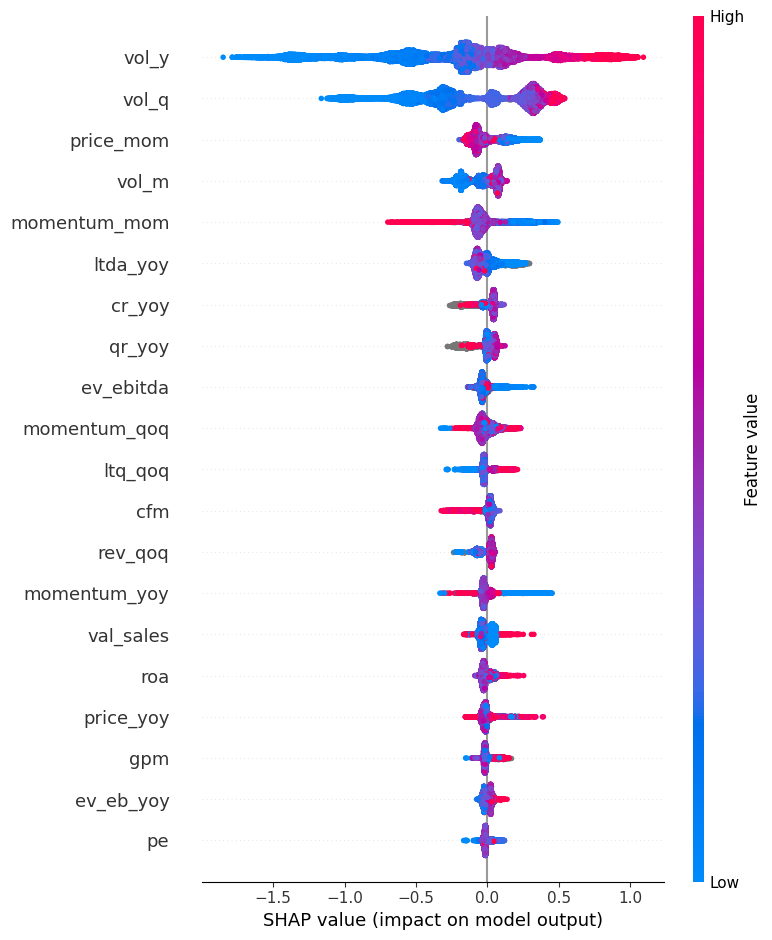

In [12]:
import shap

explainer = shap.TreeExplainer(model.model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=20)

In [13]:
import numpy as np
import pandas as pd

# Get mean absolute SHAP values per feature
shap_abs = pl.DataFrame({
    'Feature': X_train.columns,
    'Mean SHAP Value': np.mean(np.abs(shap_values), axis=0)
}).sort('Mean SHAP Value', descending=False)

print(shap_abs)

shape: (51, 2)
┌──────────────┬─────────────────┐
│ Feature      ┆ Mean SHAP Value │
│ ---          ┆ ---             │
│ str          ┆ f32             │
╞══════════════╪═════════════════╡
│ val_purch    ┆ 0.002064        │
│ ltcr_yoy     ┆ 0.002497        │
│ itr_yoy      ┆ 0.002812        │
│ ni_yoy       ┆ 0.003089        │
│ pe_qoq       ┆ 0.003166        │
│ …            ┆ …               │
│ momentum_mom ┆ 0.090413        │
│ vol_m        ┆ 0.091188        │
│ price_mom    ┆ 0.091492        │
│ vol_q        ┆ 0.36829         │
│ vol_y        ┆ 0.43977         │
└──────────────┴─────────────────┘
